# Notebook for Integrating data and removing batch-effects

## Use scvi-tools

### Import packages

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import os
import rapids_singlecell as rsc # only use this if you have a gpu; if no GPU then use sc equivalent
import scvi

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.12


In [ ]:
import logging
#reduce logging amount
# Configure logging
logging.basicConfig(level=logging.WARNING)

In [ ]:
input_dir = "data/velocyto_cellbender_processed/after_qc/indv_samples"
output_dir = "data/velocyto_cellbender_processed/after_qc/integrated"

In [ ]:
# Process all screens
samples = [f'screen-{i}' for i in range(1, 5)]

In [ ]:
adata_list = []
for sample in samples:
    #check which sample we're using
    print(f'loading {sample}' )
    # read in object
    adata = sc.read_h5ad(os.path.join(input_dir, sample + '-filtered_combined.h5ad'))
    adata_list.append(adata)

merging screen-1
merging screen-2
merging screen-3
merging screen-4


In [ ]:
# set the batches
for i,adata in enumerate(adata_list):
    adata.obs['batch'] = samples[i]
    print(adata_list[i].obs['batch'])

barcode
AGTCACATCATTTGAG    screen-1
GGGACATCTGGGTTCT    screen-1
AACACACAATGTGCCG    screen-1
AGGTCATCAGCTTTCC    screen-1
AAGCGTTGTCGAACTG    screen-1
                      ...   
CATCCACGTGTCTTGC    screen-1
CTTAGGAAGGCTAAGT    screen-1
ATCCTCACTCTGCTCA    screen-1
ATCCTCCAAAACTCTC    screen-1
GCCATGGCACTAGTAC    screen-1
Name: batch, Length: 5810, dtype: object
barcode
AGCCAATGTCGTACTT    screen-2
AGGCAATGAAGATACC    screen-2
GAGCATGCACAGCCAC    screen-2
GGCATCTCAGTCGTTA    screen-2
AGCCAATTTTCCAGTG    screen-2
                      ...   
CATTCCGACGCTGCTG    screen-2
ACCTGTCTAGTTTTGC    screen-2
GCCTTTAGAAGGTGCA    screen-2
GATTGGTGTCGGTACG    screen-2
GAGCATCTCCCGGTAC    screen-2
Name: batch, Length: 6065, dtype: object
barcode
ATTCCATCACAGTGTT    screen-3
ACCACAAACTCCTCTT    screen-3
CTGAGCGAGGCCCGCT    screen-3
AGGGTCCCGGGGGCCC    screen-3
CTGCATCTGGACAGGC    screen-3
                      ...   
CAGCCAGGAGTTTTCC    screen-3
GGAGCAGAGGGATGTC    screen-3
CTCAAGACACACCGTA    scre

### Merge the raw count matrices using `sc.concat`

In [ ]:
#merge raw, unnormalized counts
adata = sc.concat(adata_list)

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# Make obs and vars unique
adata.obs_names_make_unique()
adata.var_names_make_unique()

In [ ]:
aav = ['AAV1', 'AAV7', 'AAVDJ8', 'AAVRH10']
sum(adata.var_names.isin(aav))

4

### Save the raw object

In [ ]:
adata.write(os.path.join(output_dir, 'integrated_raw.h5ad'))

## Begin QC of the integrated object
### Start with filtering by basic metrics

In [ ]:
# perform basic filtering and QC
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 1)

filtered out 9 cells that have less than 200 genes expressed
filtered out 117 genes that are detected in less than 1 cells


In [ ]:
sum(adata.var_names.isin(aav))

4

In [ ]:
adata

AnnData object with n_obs × n_vars = 23174 × 24624
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'
    obsm: 'gene_expression_encoding'
    layers: 'spliced', 'unspliced'

### Remove doublets using SCVI-Solo

In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer = "spliced",
                             batch_key="batch",
                             #continuous_covariate_keys=['pct_counts_mt', 'total_counts']
                             )
model = scvi.model.SCVI(adata)
model.train(accelerator = 'gpu')

# catch doublets
solo = scvi.external.SOLO.from_scvi_model(model)
solo.train(accelerator = "gpu",
            )
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

print(df)
print(df.groupby('prediction').count())

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A30') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/345:   0%|          | 0/345 [00:00<?, ?it/s]

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 345/345: 100%|██████████| 345/345 [16:13<00:00,  2.82s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.74e+3] 

`Trainer.fit` stopped: `max_epochs=345` reached.


Epoch 345/345: 100%|██████████| 345/345 [16:13<00:00,  2.82s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.74e+3]


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/scvi/external/solo/_model.py:132: UserWarning: Solo should only be trained on one lane of data using `restrict_to_batch`. Performance may suffer.
  _validate_scvi_model(scvi_model, restrict_to_batch=restrict_to_batch)


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 376/400:  94%|█████████▍| 376/400 [06:53<00:26,  1.10s/it, v_num=1, train_loss_step=0.218, train_loss_epoch=0.147] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.142. Signaling Trainer to stop.
                    doublet    singlet prediction
AGTCACATCATTTGAG   1.338689  -1.560530    doublet
GGGACATCTGGGTTCT   3.024610  -3.364421    doublet
AACACACAATGTGCCG   1.908761  -1.903334    doublet
AGGTCATCAGCTTTCC  -0.724568  -0.356103    singlet
AAGCGTTGTCGAACTG   2.516095  -2.449362    doublet
...                     ...        ...        ...
AGTTTCCCATTGTAGC  -5.489775   5.012322    singlet
AGACACACAGTATTCG  -5.487002   4.966901    singlet
AGACAATCAGCGCGTT  -6.093651   5.388130    singlet
CGAATTGGTGGGCCTC  -5.636976   4.649785    singlet
CATAGACTCCTAACAG -10.155346  10.054540    singlet

[23174 rows x 3 columns]
            doublet  singlet
prediction                  
doublet        2018     2018
singlet       21156    21156


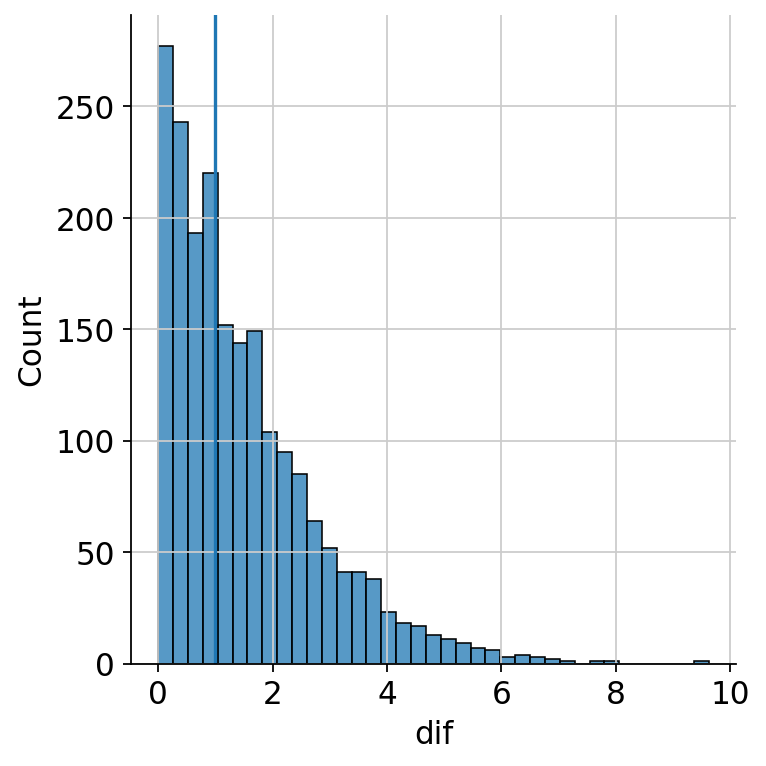

In [ ]:
df['dif'] = df.doublet - df.singlet
sns.displot(df[df.prediction == 'doublet'], x = 'dif')
plt.axvline(1)
plt.show()

In [ ]:
doublet_score_cutoff = 1
doublets = df[(df.prediction == 'doublet') & (df.dif > doublet_score_cutoff)]
doublets.shape

(1122, 4)

In [ ]:
print(adata.shape)
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata.obs
adata = adata[~adata.obs.doublet]
print(adata.shape)

(23174, 24624)
(22052, 24624)


In [ ]:
qc_metrics = ['total_counts', 'log1p_total_counts',
              'n_genes', 'n_genes_by_counts', 
              'pct_counts_mt',
              'pct_counts_in_top_20_genes']
df2 = pd.concat([x.obs for x in adata])

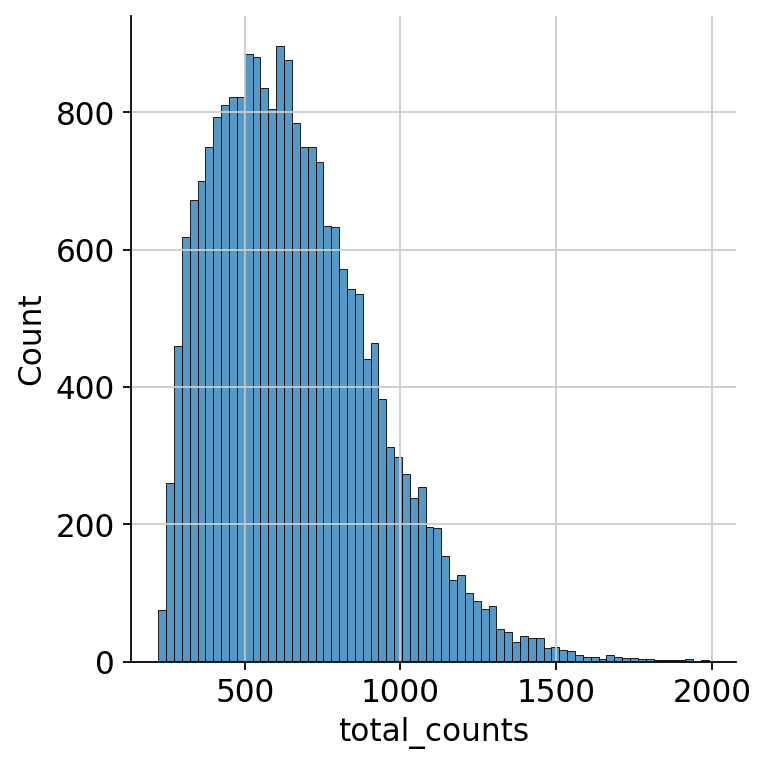

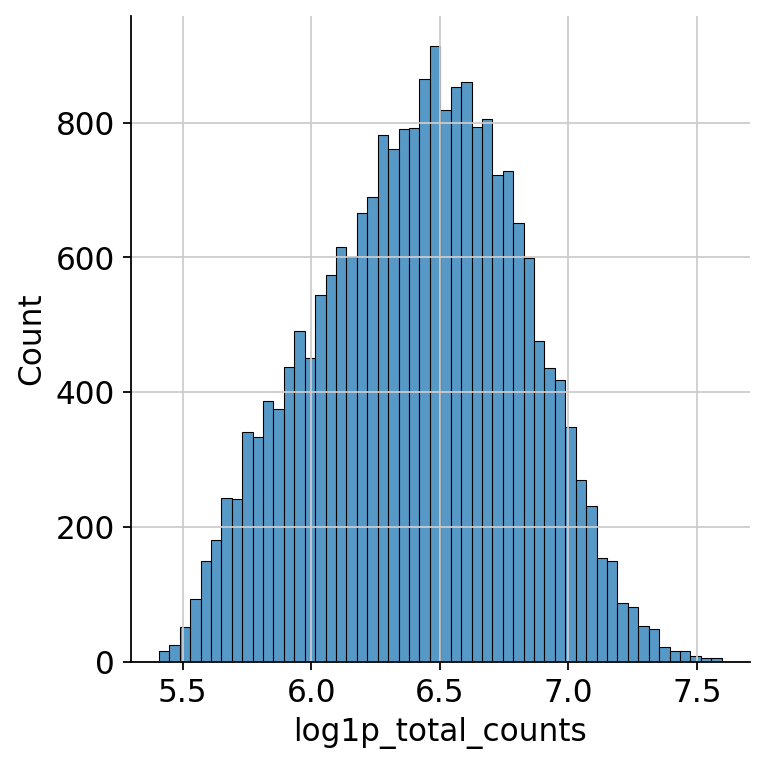

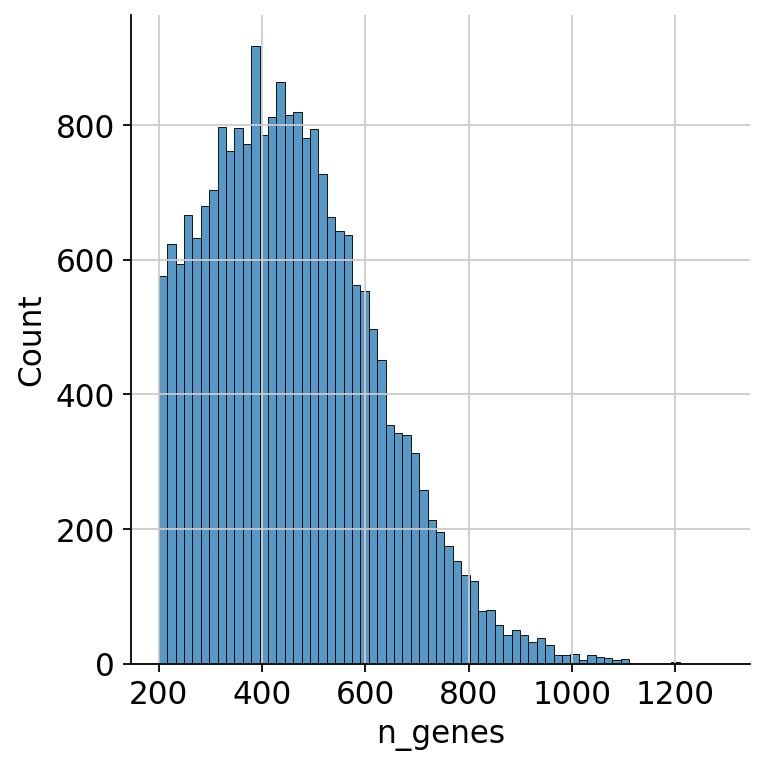

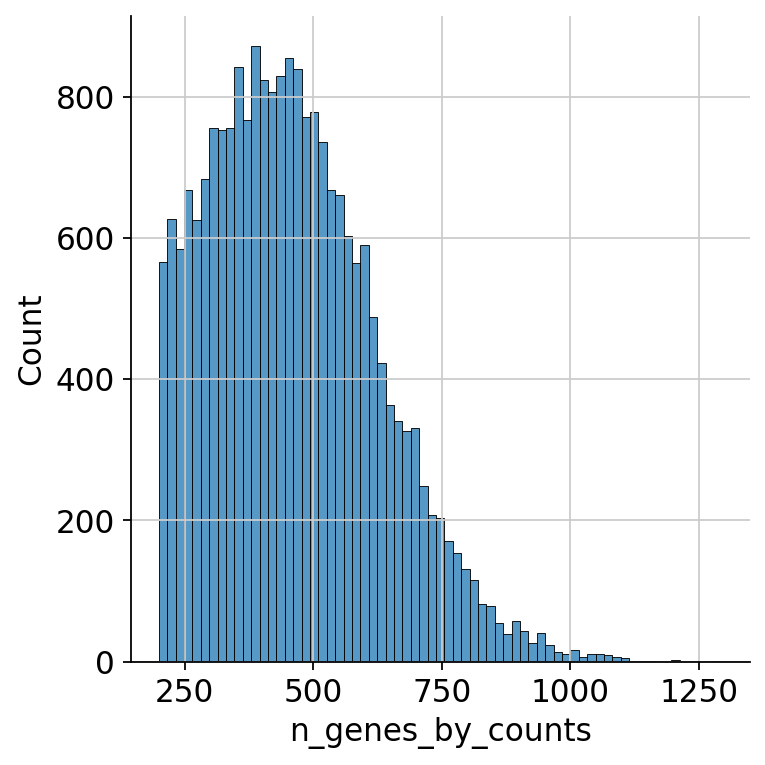

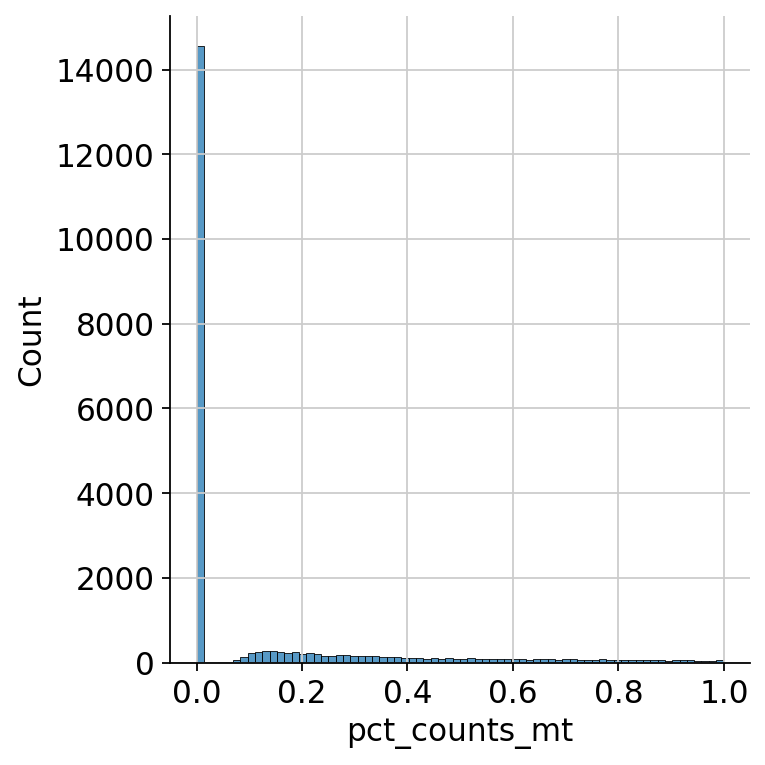

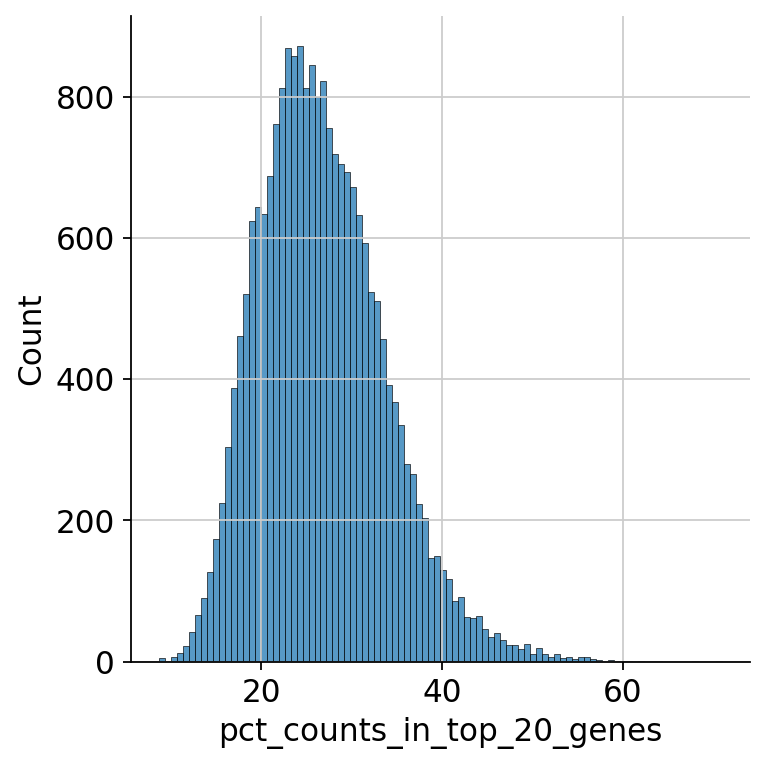

In [ ]:
for value in qc_metrics:
    sns.displot(df2[value])
    plt.show()

### Save only no doublets object prior to filtering
### just in case we need to revisit the filtering thresholds

In [ ]:
adata.write(os.path.join(output_dir, 'integrated-nodoublets.h5ad'))

In [ ]:
adata.shape

(22052, 24624)

In [ ]:
bdata = adata.copy()

### use same filtering cutoffs for integrated object as we did on individual samples
### Lower the threshold of mitochondrial percentage to 0.6 for integrated object

In [ ]:
n_genes_cutoff = 1000
total_counts_cutoff = 1500
pct_counts_mt_cutoff = .6

In [ ]:
bdata = bdata[bdata.obs.n_genes_by_counts < n_genes_cutoff]
bdata = bdata[bdata.obs.total_counts < total_counts_cutoff]
bdata = bdata[bdata.obs.pct_counts_mt < pct_counts_mt_cutoff]
print(bdata.shape)

(20081, 24624)


### Save the filtered object

In [ ]:
bdata.write(os.path.join(output_dir, 'integrated-allfilter.h5ad'))